In [ ]:
# Download và giải nén dữ liệu
!gdown https://drive.google.com/u/0/uc?id=1WHPgUnzEOgQvFK6aL-PrfI4QbR9AirYK
!unzip /content/final_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: melanoma_cancer_dataset/train/benign/melanoma_1348.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_250.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_2562.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_9789.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_4086.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_3030.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_4665.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_1161.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_3931.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_804.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_204.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_1533.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_1695.jpg  
  inflating: melanoma_cancer_dataset/train

In [ ]:
!pip install lightning
!pip install tensorboard

In [ ]:
#import thư viện
import lightning as L
import cv2
import os
import glob
import torchmetrics
import torch
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F

import torch.nn as nn
import torch.nn.functional as Func

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

## **Create dataset**

In [ ]:
# Lấy tên của 2 thư mục nằm trong thư mục train, cũng chính là nhãn của dữ liệu
train_path = "melanoma_cancer_dataset/train/"
list_ = [name for name in os.listdir(train_path)]

In [ ]:
# Đánh số cho nhãn của dữ liệu
NAME2NUMBER = {}
for index, label in enumerate(list_):
  NAME2NUMBER[label] = index
print(NAME2NUMBER)

# Tạo hàm get_path để lấy đường dẫn và label tương ứng với từng ảnh
def get_path(path):
  paths = []
  for name in list_:
    l = glob.glob(f"{path}{name}/*.jpg")
    for i in l:
      paths.append({"name": name,
                    "path": i,
                    "label": NAME2NUMBER[name]})
  return paths

train_paths = get_path(train_path)

{'malignant': 0, 'benign': 1}


,name,path,label
0,malignant,melanoma_cancer_dataset/train/malignant/melano...,0
1,malignant,melanoma_cancer_dataset/train/malignant/melano...,0
2,malignant,melanoma_cancer_dataset/train/malignant/melano...,0
3,malignant,melanoma_cancer_dataset/train/malignant/melano...,0
4,malignant,melanoma_cancer_dataset/train/malignant/melano...,0


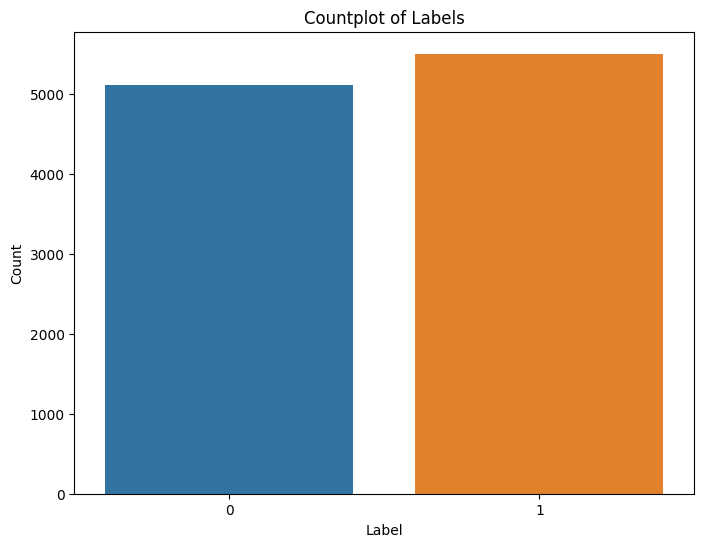

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(train_paths)  # Chuyển danh sách dữ liệu thành DataFrame
display(df.head())
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="label")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Countplot of Labels')
plt.show()

In [ ]:
# khởi tạo lớp Dataset để đọc dữ liệu, chuẩn hóa và transform dữ liệu
# Cuối cùng, trả về một dictionary chứa tensor hình ảnh và tensor nhãn.
class DataSet(torch.utils.data.Dataset):

  def __init__(self, features, transform=None):
    super(DataSet, self).__init__()
    self.features = features
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    paths = self.features[idx]["path"]
    image = torchvision.io.read_image(paths) / 255.0

    if self.transform is not None:
        image = self.transform(image)

    label = torch.tensor(self.features[idx]["label"])
    return {"image": image,
            "label": label}

Data = DataSet(train_paths)
next(iter(Data))["image"].shape

torch.Size([3, 300, 300])

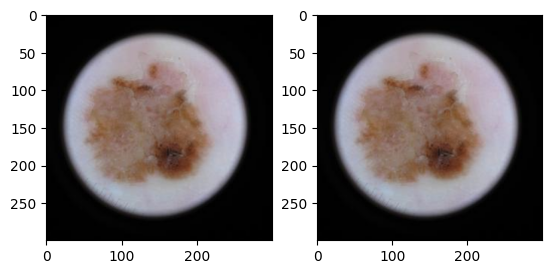

In [ ]:
# Hàm show ảnh từ tensor
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))

show([next(iter(Data))["image"], next(iter(Data))["image"]])

In [ ]:
#Khởi tạo lớp DataMudule
class DataModule(L.LightningDataModule):
  def __init__(self, batch_size, num_workers, train_path):
    super(DataModule, self).__init__()
    self.train_path = train_path
    self.batch_size = batch_size
    self.num_workers = num_workers
    # Tạo bước transforms cho tập train
    self.train_transforms = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.RandomRotation(30),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]
    )
    # Tạo bước tranforms cho tập test và validate
    self.test_transforms = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]
    )
  # Tách tập train thành tập train, test và validate
  # Sau đó, ta khởi tạo các đối tượng DataSet cho các tập dữ liệu tương ứng và cài đặt các transform tương ứng
  def setup(self, stage=None):
    train_paths = get_path(self.train_path)
    train_paths, test_paths = train_test_split(train_paths, test_size=0.2, random_state=0)
    train_paths, val_paths = train_test_split(train_paths, test_size=0.1, random_state=0)

    self.train_dataset = DataSet(train_paths, transform=self.train_transforms)
    self.val_dataset = DataSet(val_paths, transform=self.test_transforms)
    self.test_dataset = DataSet(test_paths, transform=self.test_transforms)

  def train_dataloader(self):
    return torch.utils.data.DataLoader(self.train_dataset, shuffle=True,
                                      batch_size=self.batch_size, num_workers=self.num_workers)
  def val_dataloader(self):
    return torch.utils.data.DataLoader(self.val_dataset, shuffle=False,
                                      batch_size=self.batch_size, num_workers=self.num_workers)
  def test_dataloader(self):
    return torch.utils.data.DataLoader(self.test_dataset, shuffle=False,
                                      batch_size=self.batch_size, num_workers=self.num_workers)


data_module = DataModule(8, 0, train_path)
data_module.setup()
train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()
next(iter(train_loader))["image"].shape

torch.Size([8, 3, 224, 224])

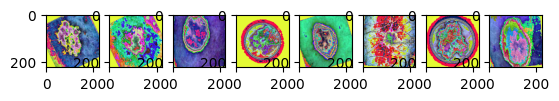

In [ ]:
images = [image for image in next(iter(train_loader))["image"]]
show(images)

# **Training Model**

Thí nghiệm training với 3 model khác nhau để lựa chọn model phù hợp nhất để sử dụng cho bài toán phân loại Skin Cancer (có 2 labels), gồm có:
- VGG16
- ResNet50
- ResNet152

## **VGG16**

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        # mô hình sẽ trích xuất những đặc trưng quan trọng trong dữ liệu thông qua hàm self._make_layer().
        self.features = self._make_layers()
        # Để thực hiện phân loại dựa trên đặc trưng đã trích xuất, ta đưa những đặc trưng này vào các lớp tuyến tính và các lớp kích hoạt ReLU và Dropout.
        self.classifier = nn.Sequential(
            # Một lớp tuyến tính với đầu vào là 512 * 7 * 7 (kích thước đầu ra của phần features) và đầu ra là 4096.
            nn.Linear(512 * 7 * 7, 4096),
            # Lớp kích hoạt ReLU.
            nn.ReLU(inplace=True),
            # Lớp Dropout để ngẫu nhiên tắt các đơn vị đầu ra với xác suất p = 0.5.
            nn.Dropout(),
            # Một lớp tuyến tính với đầu vào là 4096 và đầu ra cũng là 4096.
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            # Một lớp tuyến tính cuối cùng với đầu vào là 4096 và đầu ra là số lớp đầu ra cuối cùng (num_classes).
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        # Đưa dữ liệu đầu vào self.feature để trích xuất dữ liệu
        x = self.features(x)
        # Thay đổi kích thước của dữ liệu đầu vào
        x = x.view(x.size(0), -1)
        # phân loại dữ liệu
        x = self.classifier(x)

        return x

    def _make_layers(self):
       #Trước tiên, chúng ta khởi tạo một danh sách trống layers để lưu các lớp.
        layers = []
        # Tiếp theo, ta khởi tạo số kênh đầu vào in_channels là 3 (3 kênh màu RGB của ảnh đầu vào).
        in_channels = 3
        # Một danh sách vgg_config được định nghĩa để xác định kiến trúc của mô hình VGG16.
        vgg_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

        for idx, v in enumerate(vgg_config):
            # Với mỗi phần tử v trong vgg_config, ta kiểm tra xem nó có phải là lớp tối đa pooling ('M') hay không.
            # Nếu đúng, ta thêm một lớp MaxPool2d vào danh sách layers với kernel size là 2 và stride là 2.
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
              # Nếu v không phải là lớp tối đa pooling, ta tạo một lớp tích chập Conv2d với số kênh đầu vào là in_channels, số kênh đầu ra là v, và kernel size là 3 và padding là 1 (để đảm bảo kích thước đầu ra không thay đổi).
              # Sau đó, ta thêm lớp tích chập và lớp kích hoạt ReLU vào danh sách layers.
              # Cuối cùng, ta cập nhật số kênh đầu vào in_channels thành v
                if idx in [8, 12, 16]:
                  conv = nn.Conv2d(in_channels, v, kernel_size=1)
                else:
                  conv = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)

                layers += [conv, nn.ReLU(inplace=True)]
                in_channels = v
        # Trả về một nn.Sequential của danh sách layers
        return nn.Sequential(*layers)

In [ ]:
# Define a LightningModule using the custom VGG16
class Model_VGG16(L.LightningModule):
  # Trong hàm khởi tạo init, ta khởi tạo mô hình VGG16 và gán mô hình vào self.model.
  # Sau đó, ta cũng khởi tạo learning rate, loss function (torch.nn.CrossEntropyLoss()) và các độ đo đánh giá như accuracy, F1 score, recall và precision từ torchmetrics.classification.
    def __init__(self,  num_classes=2, lr=1e-3):
        super(Model_VGG16, self).__init__()
        self.model = VGG16(num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.classification.BinaryAccuracy()
        self.f1 = torchmetrics.classification.BinaryF1Score()
        self.recall = torchmetrics.classification.BinaryRecall()
        self.precision = torchmetrics.classification.BinaryPrecision()

     # Trong hàm forward, nhiệm vụ đơn giản của hàm này là đưa dữ liệu đầu vào vào mô hình self.model.
    def forward(self, x):
        return self.model(x)

    # Hàm train_step được gọi là hàm huấn luyện mô hình Trong quá trình này, ta nhận một batch dữ liệu và thực hiện các bước sau
    def training_step(self, batch, batch_idx):
        # Trích xuất ảnh và nhãn từ batch
        images, labels= batch['image'], batch['label']
        # Tiến hành lan truyền thuận (forward pass) qua mô hình để có được đầu ra dự đoán.
        outputs = self(images)
        # Tính toán loss bằng cách so sánh đầu ra dự đoán với nhãn sử dụng loss function.
        loss = self.loss(outputs, labels)
        # Ghi log loss và accuracy để theo dõi quá trình huấn luyện.
        accuracy = (outputs.argmax(dim=1) == labels).float().mean()
        # Trả về loss để cập nhật các trọng số của mô hình.
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    # Hàm validation_step được gọi trong quá trình đánh giá. Các bước thực hiện hàm đánh giá này giống như hàm train_step.
    def validation_step(self, batch, batch_idx):

        images, labels= batch['image'], batch['label']

        # Forward pass
        outputs = self(images)

        val_loss = self.loss(outputs, labels)

        accuracy = (outputs.argmax(dim=1) == labels).float().mean()
        self.log_dict({'val_loss': val_loss, 'acc': accuracy}, prog_bar=True)
        return val_loss

    # Phương thức test_step được gọi trong quá trình kiểm tra (testing). Tương tự như validation_step, ta nhận một batch dữ liệu và thực hiện các bước sau:
    def test_step(self, batch, batch_idx):
        # Trích xuất ảnh và nhãn từ batch.
        images, labels= batch['image'], batch['label']

        # Tiến hành lan truyền thuận (forward pass) qua mô hình để có được đầu ra dự đoán.
        outputs = self(images)

         # Tính toán loss bằng cách so sánh đầu ra dự đoán với nhãn sử dụng loss function.
        test_loss = self.loss(outputs, labels)

        # Tính toán các độ đo đánh giá như accuracy, F1 score, recall và precision sử dụng các đối tượng được khởi tạo trong hàm init.
        # Ghi log các giá trị loss và các độ đo đánh giá để theo dõi quá trình kiểm tra.
        predictions = torch.argmax(outputs, dim=1)
        accuracy = self.accuracy(predictions, labels)
        f1 = self.f1(predictions, labels)
        recall = self.recall(predictions, labels)
        precision = self.precision(predictions, labels)
        self.log_dict({"test_loss": test_loss,
                       "accuracy": accuracy,
                       "f1": f1,
                       "recall": recall,
                       "precision": precision},
                      prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        images, labels = batch['image'], batch['label']
        outputs = self(images)

        probabilities = torch.softmax(outputs, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpointVGG16/',
                                   monitor="val_loss",
                                   verbose=True,
                                   mode="min",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]
logger = TensorBoardLogger("tb_logs", name="VGG16")
batch_size = 128
num_workers = 2
data_module = DataModule( batch_size, num_workers, train_path)
model = Model_VGG16()

In [ ]:
trainer = L.Trainer(max_epochs=10, logger=logger, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, data_module)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 60: 'val_loss' reached 0.50076 (best 0.50076), saving model to '/content/checkpointVGG16/epoch=0-step=60.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 60: 'val_loss' reached 0.50076 (best 0.50076), saving model to '/content/checkpointVGG16/epoch=0-step=60.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 120: 'val_loss' reached 0.39918 (best 0.39918), saving model to '/content/checkpointVGG16/epoch=1-step=120.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 120: 'val_loss' reached 0.39918 (best 0.39918), saving model to '/content/checkpointVGG16/epoch=1-step=120.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 180: 'val_loss' reached 0.36856 (best 0.36856), saving model to '/content/checkpointVGG16/epoch=2-step=180.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 180: 'val_loss' reached 0.36856 (best 0.36856), saving model to '/content/checkpointVGG16/epoch=2-step=180.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 240: 'val_loss' reached 0.28201 (best 0.28201), saving model to '/content/checkpointVGG16/epoch=3-step=240.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 240: 'val_loss' reached 0.28201 (best 0.28201), saving model to '/content/checkpointVGG16/epoch=3-step=240.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 300: 'val_loss' reached 0.28066 (best 0.28066), saving model to '/content/checkpointVGG16/epoch=4-step=300.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 300: 'val_loss' reached 0.28066 (best 0.28066), saving model to '/content/checkpointVGG16/epoch=4-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 360: 'val_loss' reached 0.24898 (best 0.24898), saving model to '/content/checkpointVGG16/epoch=5-step=360.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 360: 'val_loss' reached 0.24898 (best 0.24898), saving model to '/content/checkpointVGG16/epoch=5-step=360.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 420: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 420: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 480: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 480: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 540: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 540: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 600: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 600: 'val_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.8755304217338562     │
│            f1             │    0.8879941701889038     │
│         precision         │    0.8387908935546875     │
│          recall           │    0.9446787238121033     │
│         test_loss         │    0.29105812311172485    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.29105812311172485,
  'accuracy': 0.8755304217338562,
  'f1': 0.8879941701889038,
  'recall': 0.9446787238121033,
  'precision': 0.8387908935546875}]

In [ ]:
#%tensorboard --logdir tb_logs/VGG16

Nhận xét: Mô hình VGG16 có hiệu suất tương đối tốt trong bài toán phân loại khối u da ác tính và lành tính (Skin Cancer). Với Recall đạt khoảng 94.5%, metric đạt kết quả cao nhất trên tập dữ liệu kiểm tra, cho thấy mô hình có khả năng phát hiện các khối u da ác tính tương đối tốt.

## **ResNet50**

In [ ]:
# Import các thư viện cần thiết
import lightning.pytorch as L
import torchvision
import torch
import torchmetrics

# Định nghĩa một lớp ResNet50 kế thừa từ lớp LightningModule
class ResNet50(L.LightningModule):
  # Hàm khởi tạo lớp
  def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2):
    """
    Hàm này khởi tạo các thuộc tính và phương thức của lớp ResNet50
    :param is_train: một biến logic, xác định xem có huấn luyện lớp backbone hay không, mặc định là False
    :param learning_rate: một số thực, xác định tốc độ học của mô hình, mặc định là 1e-4
    :param num_target_classes: một số nguyên, xác định số lượng lớp mục tiêu của bài toán phân loại, mặc định là 2 vì bài toán có 2 labels
    """
    # Gọi hàm khởi tạo của lớp cha
    super(ResNet50, self).__init__()
    # Tạo một mô hình backbone là ResNet50 có sẵn trong torchvision
    backbone = torchvision.models.resnet50(weights="DEFAULT")
    # Lấy số lượng bộ lọc của lớp kết nối đầy đủ cuối cùng của backbone, để sử dụng làm số lượng đầu vào cho lớp fully connected của classifier
    num_filters = backbone.fc.in_features
    # Lấy danh sách các lớp của backbone trừ lớp kết nối đầy đủ cuối cùng, để sử dụng làm các lớp của bộ trích xuất đặc trưng
    layers = list(backbone.children())[:-1]

    # Tạo một bộ trích xuất đặc trưng là một chuỗi các lớp của backbone, bằng cách truyền danh sách các lớp vào hàm Sequential
    self.feature_extractor = torch.nn.Sequential(*layers)
    # Tạo một bộ phân loại là một lớp fully connected với số lượng đầu ra bằng số lượng lớp mục tiêu
    self.classifier = torch.nn.Linear(num_filters, num_target_classes)

    self.is_train = is_train # is_train = False -> Không train lớp backbone
    self.learning_rate = learning_rate # Lưu trữ tốc độ học
    self.loss = torch.nn.CrossEntropyLoss() # Tạo một hàm mất mát là hàm entropy chéo

    # Tạo các phép đo độ chính xác cho bài toán phân loại nhị phân
    self.accuracy = torchmetrics.classification.Accuracy(task="binary", num_classes=num_target_classes)
    self.precision = torchmetrics.classification.Precision(task="binary", num_classes=num_target_classes)
    self.recall = torchmetrics.classification.Recall(task="binary", num_classes=num_target_classes)
    self.f1_score = torchmetrics.classification.F1Score(task="binary", num_classes=num_target_classes)


  # Hàm lan truyền thuận
  def forward(self, x):
    """
    Hàm này tính toán các giá trị đầu ra của mô hình khi cho dữ liệu đầu vào x
    :param x: một tensor, chứa dữ liệu ảnh đầu vào, có kích thước là (batch_size, 3, height, width)
    :return: một tensor, chứa các giá trị đầu ra của mô hình, có kích thước là (batch_size, num_target_classes)
    """
    self.feature_extractor.eval() # Đặt bộ trích xuất đặc trưng ở chế độ đánh giá

    if self.is_train: # Nếu không train lớp backbone
      representations = self.feature_extractor(x).flatten(1)
    else: # Ngược lại
      with torch.no_grad():
        representations = self.feature_extractor(x).flatten(1)

    x = self.classifier(representations)
    return x

  def training_step(self, batch, batch_idx):
    """
    Hàm này huấn luyện mô hình một bước với dữ liệu từ batch
    :param batch: một từ điển, chứa dữ liệu ảnh và nhãn từ batch
    :param batch_idx: một số nguyên, xác định chỉ số của batch
    :return: một số thực, chứa giá trị mất mát của bước huấn luyện
    """
    # Lấy dữ liệu ảnh và nhãn từ batch
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x) # Tính toán các giá trị dự đoán của x bằng cách đi qua mô hình

     # Tính toán giá trị loss và giá trị các độ đo
    loss = self.loss(y_pred, y)
    accuracy = (y_pred.argmax(dim=1) == y).float().mean()

    self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True) # Lưu lại các giá trị loss và giá trị của các độ đo

    return loss

  def validation_step(self, batch, batch_idx):
      """
      Hàm này đánh giá mô hình một bước với dữ liệu từ batch
      :param batch: một từ điển, chứa dữ liệu ảnh và nhãn từ batch
      :param batch_idx: một số nguyên, xác định chỉ số của batch
      :return: một số thực, chứa giá trị mất mát của bước đánh giá
      """
      # Lấy dữ liệu ảnh và nhãn từ batch
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x) # Tính toán các giá trị dự đoán của x bằng cách đi qua mô hình

      # Tính toán giá trị loss và giá trị các độ đo
      val_loss = self.loss(y_pred, y)
      val_accuracy = (y_pred.argmax(dim=1) == y).float().mean()

      self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True) # Lưu lại các giá trị loss và giá trị của các độ đo

      return val_loss

  def test_step(self, batch, batch_idx):
      """
      Hàm này đánh giá mô hình một bước với dữ liệu từ batch
      :param batch: một từ điển, chứa dữ liệu ảnh và nhãn từ batch
      :param batch_idx: một số nguyên, xác định chỉ số của batch
      :return: một số thực, chứa giá trị mất mát của bước đánh giá
      """
      # Lấy dữ liệu ảnh và nhãn từ batch
      x = batch["image"]
      y = batch["label"]
      y_pred = self(x)
      preds = torch.argmax(y_pred, dim=1)

      # Tính toán giá trị loss và giá trị các độ đo
      test_loss = self.loss(y_pred, y)
      test_accuracy = self.accuracy(preds, y)
      test_recall = self.recall(preds, y)
      test_precision = self.precision(preds, y)
      test_f1_score = self.f1_score(preds, y)

      self.log_dict({'test_loss': test_loss,
                     'accuracy': test_accuracy,
                     'recall': test_recall,
                     'precision': test_precision,
                     'f1_score': test_f1_score}, prog_bar=True)

      return test_loss

  # Hàm dự đoán một bước trên một hoặc nhiều tập dữ liệu
  def predict_step(self, batch, batch_idx, dataloader_idx=None):
      """
      Hàm này dự đoán nhãn của dữ liệu từ batch
      :param batch: một từ điển, chứa dữ liệu ảnh và nhãn từ batch
      :param batch_idx: một số nguyên, xác định chỉ số của batch
      :param dataloader_idx: một số nguyên hoặc None, xác định chỉ số của tập dữ liệu, mặc định là None
      :return: một từ điển, chứa nhãn dự đoán của dữ liệu, có khóa là "y_pred"
      """
      # Lấy dữ liệu ảnh và nhãn từ batch
      x, y = batch['image'], batch['label']
      # Tính toán các giá trị đầu ra của x bằng cách đi qua mô hình
      y_hat = self(x)

      # Tính toán xác suất của các lớp mục tiêu bằng cách áp dụng hàm softmax cho các giá trị đầu ra
      probabilities = torch.softmax(y_hat, dim=1)
      # Tính toán nhãn dự đoán bằng cách lấy chỉ số của giá trị lớn nhất trong xác suất
      predicted_labels = torch.argmax(probabilities, dim=1)

      # Trả về một từ điển chứa nhãn dự đoán
      return {"y_pred": predicted_labels}

  # Hàm cấu hình bộ tối ưu hóa
  def configure_optimizers(self):
      """
      Hàm này cấu hình optimizer cho mô hình
      :return: một optimizer, sử dụng Adam
      """
      # Sử dụng optimizer là Adam
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer


In [ ]:
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

model_checkpoint = ModelCheckpoint(dirpath='checkpointResNet50/',
                                   monitor="val_loss",
                                   verbose=True,
                                   mode="min",
                                   save_top_k=1)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]
logger = TensorBoardLogger("tb_logs", name="ResNet50")
model = ResNet50()
data_module = DataModule(128, 2, train_path)
data_module.setup()

test_loader = data_module.test_dataloader()
print(len(test_loader))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


17


In [ ]:
trainer = L.Trainer(max_epochs=10, logger = logger, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, data_module)

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 60: 'val_loss' reached 0.28319 (best 0.28319), saving model to '/content/checkpointResNet50/epoch=0-step=60.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 60: 'val_loss' reached 0.28319 (best 0.28319), saving model to '/content/checkpointResNet50/epoch=0-step=60.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 120: 'val_loss' reached 0.24900 (best 0.24900), saving model to '/content/checkpointResNet50/epoch=1-step=120.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 120: 'val_loss' reached 0.24900 (best 0.24900), saving model to '/content/checkpointResNet50/epoch=1-step=120.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 180: 'val_loss' reached 0.24349 (best 0.24349), saving model to '/content/checkpointResNet50/epoch=2-step=180.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 180: 'val_loss' reached 0.24349 (best 0.24349), saving model to '/content/checkpointResNet50/epoch=2-step=180.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 240: 'val_loss' reached 0.22924 (best 0.22924), saving model to '/content/checkpointResNet50/epoch=3-step=240.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 240: 'val_loss' reached 0.22924 (best 0.22924), saving model to '/content/checkpointResNet50/epoch=3-step=240.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 300: 'val_loss' reached 0.22222 (best 0.22222), saving model to '/content/checkpointResNet50/epoch=4-step=300.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 300: 'val_loss' reached 0.22222 (best 0.22222), saving model to '/content/checkpointResNet50/epoch=4-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 360: 'val_loss' reached 0.21353 (best 0.21353), saving model to '/content/checkpointResNet50/epoch=5-step=360.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 360: 'val_loss' reached 0.21353 (best 0.21353), saving model to '/content/checkpointResNet50/epoch=5-step=360.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 420: 'val_loss' reached 0.21278 (best 0.21278), saving model to '/content/checkpointResNet50/epoch=6-step=420.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 420: 'val_loss' reached 0.21278 (best 0.21278), saving model to '/content/checkpointResNet50/epoch=6-step=420.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 480: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 480: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 540: 'val_loss' reached 0.20798 (best 0.20798), saving model to '/content/checkpointResNet50/epoch=8-step=540.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 540: 'val_loss' reached 0.20798 (best 0.20798), saving model to '/content/checkpointResNet50/epoch=8-step=540.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 600: 'val_loss' reached 0.20525 (best 0.20525), saving model to '/content/checkpointResNet50/epoch=9-step=600.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 600: 'val_loss' reached 0.20525 (best 0.20525), saving model to '/content/checkpointResNet50/epoch=9-step=600.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.9108911156654358     │
│         f1_score          │     0.914378821849823     │
│         precision         │    0.9165434241294861     │
│          recall           │    0.9137915372848511     │
│         test_loss         │    0.23186855018138885    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.23186855018138885,
  'accuracy': 0.9108911156654358,
  'recall': 0.9137915372848511,
  'precision': 0.9165434241294861,
  'f1_score': 0.914378821849823}]

### Nhận xét:
-  Mô hình đạt được kết quả tương đối tốt trên tập dữ liệu test với các metrics đều cao và giá trị hàm mất mát thấp.
- Có vẻ như mô hình chưa hội tụ hoặc chưa hội tụ đủ, có thể điều chỉnh tăng epochs hoặc điều chỉnh các hyperparameters.

In [ ]:
#%tensorboard --logdir tb_logs/ResNet50

## **ResNet152**

In [ ]:
class ResNet152(L.LightningModule):
  def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2):
    super(ResNet152, self).__init__()
    backbone = torchvision.models.resnet152(weights="DEFAULT")
    num_filters = backbone.fc.in_features
    layers = list(backbone.children())[:-1]

    self.feature_extractor = torch.nn.Sequential(*layers)
    self.classifier = torch.nn.Linear(num_filters, num_target_classes)
    self.is_train = is_train
    self.learning_rate = learning_rate
    self.loss = torch.nn.CrossEntropyLoss()

    self.accuracy = torchmetrics.classification.Accuracy(task="binary", num_classes=num_target_classes)
    self.precision = torchmetrics.classification.Precision(task="binary", num_classes=num_target_classes)
    self.recall = torchmetrics.classification.Recall(task="binary", num_classes=num_target_classes)
    self.f1_score = torchmetrics.classification.F1Score(task="binary", num_classes=num_target_classes)


  def forward(self, x):
    self.feature_extractor.eval()
    if self.is_train:
      representations = self.feature_extractor(x).flatten(1)
    else:
      with torch.no_grad():
        representations = self.feature_extractor(x).flatten(1)
    x = self.classifier(representations)
    return x

  def training_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    loss = self.loss(y_pred, y)
    #acc = self.accuracy(y_pred, y)
    acc = (y_pred.argmax(dim=1) == y).float().mean()
    self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    val_loss = self.loss(y_pred, y)
    #val_acc = self.accuracy(y_pred, y)
    val_acc = (y_pred.argmax(dim=1) == y).float().mean()
    self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    test_loss = self.loss(y_pred, y)
    preds = torch.argmax(y_pred, dim=1)

    acc = self.accuracy(preds, y)
    precision = self.precision(preds, y)
    recall = self.recall(preds, y)
    f1 = self.f1_score(preds, y)

    self.log_dict({'test_loss': test_loss, 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1-score': f1}, prog_bar=True)
    #self.log_dict({'test_loss': loss, 'accuracy': acc}, prog_bar=True)
    return test_loss

  def predict_step(self, batch, batch_idx, dataloader_idx=None):
    x = batch["image"]
    y_pred = self(x)
    probs = torch.nn.functional.softmax(y_pred, dim=1)
    preds = torch.argmax(probs, dim=1)
    return preds


  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)  #
    return optimizer

NameError: name 'L' is not defined

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpointResNet152/',
                                   monitor="val_loss",
                                   verbose=True,
                                   mode="min",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]
logger = TensorBoardLogger("tb_logs", name="ResNet152")
model = ResNet152()
data_module = DataModule(128, 1, train_path)
trainer = L.Trainer(max_epochs=10, logger = logger, detect_anomaly=True, callbacks=callbacks)

In [ ]:
trainer.fit(model, data_module)

In [ ]:
trainer.test(model, data_module)

In [ ]:
#%tensorboard --logdir tb_logs/ResNet152

- Khởi tạo mô hình RESNET152 ( với learning_rate là 1e-3, là mô hình phân loại gồm 2 labels dùng CrossEntropyLoss() và sử dụng các độ đo như accuracy, precision, recall và f1 để đánh giá hiệu suất của mô hình
- Log ghi nhận các kết quả trong quá trình train
# Nhận xét:
- Thử train model với lr=1e-4 thì kết quả cho ra không tốt, val_loss cao hơn so với khi sử dụng lr=1e-3 (val_loss=0.34 sau 10 epochs)
- Train model với lr=1e-3 nhanh hội tụ hơn với kết quả accuracy khi test là: 0.90

# **Conclusion**

Bài toán phân loại khối u da ác tính và lành tính (Skin Cancer) là một bài toán quan trọng trong lĩnh vực y tế và có thể được giải quyết bằng sử dụng các mô hình deep learning đã được huấn luyện trước như VGG16, ResNet50 và ResNet152. Các mô hình này đã được huấn luyện trên tập dữ liệu ImageNet.
### **Lựa chọn metrics**
Sử dụng Recall bởi vì Recall (Sensitivity, True Positive Rate) đo lường tỷ lệ các khối u ác tính được phát hiện đúng trên tổng số các khối u ác tính thực tế. Điều này giúp giảm tỉ lệ nhận nhầm khối u ác tính qua khối u lành tính, hay nói cách khác nhận định người đang mắc bệnh ung thư sang người khỏe mạnh.

### **So sánh các mô hình**

Việc lựa chọn mô hình và các mô hình có thể đạt được hiệu suất cao sẽ phụ thuộc vào nhiều yếu tố như yêu cầu về tài nguyên, độ chính xác mong muốn. Nhưng để so sánh một cách công bằng giữa VGG16, ResNet50 và ResNet152, nhóm chúng em lựa chọn 10 epochs và learning rate bằng 1e-3 để huấn luyện các mô hình. Dưới đây là bảng so sánh:

| mô hình     | params | test_closs | test_acc |Recall metric |
|-------------|--------|------------|----------|--------------|
| VGG16       | 128M   | 0.29       | 0.875    | 0.944         |
| ResNet50    | 23.5M  | 0.23       | 0.910    | 0.913         |
| ResNet152   | 58.1M  | 0.24       | 0.905    |0.885         |  

#### **Nhận xét**:
- VGG16 có số lượng tham số lớn hơn nhiều so với ResNet50 và ResNet152. Điều này có thể dẫn đến tốn kém về tài nguyên, quá trình tính toán gradient và cập nhật trọng số mô hình sẽ mất nhiều thời gian hơn.
- Dựa trên các metric đánh giá, nhóm chúng em rút ra một số nhận xét sau:
    - **Test loss**: Các mô hình ResNet50 và ResNet152 có test loss thấp hơn so với VGG16, cho thấy khả năng học tập và khái quát hoá tốt hơn của hai mô hình này trong việc dự đoán đúng hơn trên tập dữ liệu kiểm tra.
    - **test_acc**: Mô hình ResNet50 có test accuracy cao nhất (0.910), theo sau bởi ResNet152 (0.905) và VGG16 (0.875). Điều này cho thấy ResNet50 có khả năng phân loại chính xác cao nhất trên tập dữ liệu kiểm tra.
    - **Recall metric**: Recal metric đo lường khả năng của mô hình trong việc phát hiện các positive instances. VGG16 có recall metric cao nhất (0.944), tiếp theo là ResNet50 (0.913) và ResNet152 (0.885). Điều này cho thấy VGG16 có khả năng phát hiện các positive instances tốt hơn trong bài toán cụ thể này. Đây có thể là lựa chọn nếu việc bắt những trường hợp dương tính (khối u ác tính) là ưu tiên hàng đầu.